In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import cv2
import glob
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
PATH_TRAIN = r"CV-Drone-Detection/scaled/train"
PATH_TEST = r"CV-Drone-Detection/scaled/test"
PATH_VALID = r"CV-Drone-Detection/scaled/valid"


transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.Resize((128)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.ImageFolder(root=PATH_TRAIN, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

validset = torchvision.datasets.ImageFolder(root=PATH_VALID, transform=transform)
validloader = DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)

Classes: ['drone', 'notAdrone']


In [67]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [69]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
def train(model, train_loader, valid_loader, criterion, optimizer, device, epochs=5):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        valid_loss = 0
        correct = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        valid_loss /= len(valid_loader.dataset)
        accuracy = correct / len(valid_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}")

In [71]:
train(model, trainloader, validloader, loss_function, optimizer, device=device, epochs=5)

Epoch 1/5, Train Loss: 0.2381, Valid Loss: 0.1183, Accuracy: 0.9579
Epoch 2/5, Train Loss: 0.1377, Valid Loss: 0.0974, Accuracy: 0.9646
Epoch 3/5, Train Loss: 0.1138, Valid Loss: 0.0738, Accuracy: 0.9761
Epoch 4/5, Train Loss: 0.0977, Valid Loss: 0.0720, Accuracy: 0.9751
Epoch 5/5, Train Loss: 0.0858, Valid Loss: 0.0639, Accuracy: 0.9799


In [110]:
test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
])

testset = torchvision.datasets.ImageFolder(root=PATH_VALID, transform=test_transform)
testloader = DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

In [73]:
len(validloader)

262

In [74]:
correct = 0
total = 0


with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total), correct, total)


Accuracy of the network on the  test images: 77 % 809 1046


In [86]:
post_testing_pth = r'drive/MyDrive/post_testing/'

In [102]:
def img_pth(post_testing_pth):
  return glob.glob(post_testing_pth + "*.jpg") + glob.glob(post_testing_pth + "*.jpeg") + glob.glob(post_testing_pth + "*.png")

imgs = img_pth(post_testing_pth)

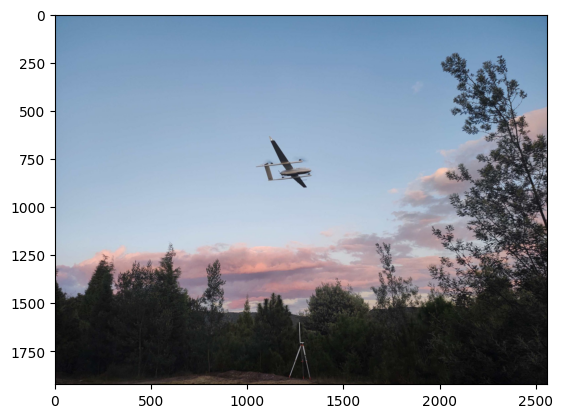


 prediction - drone 



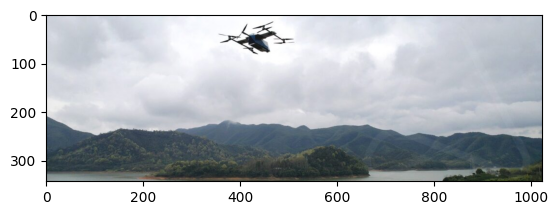


 prediction - drone 



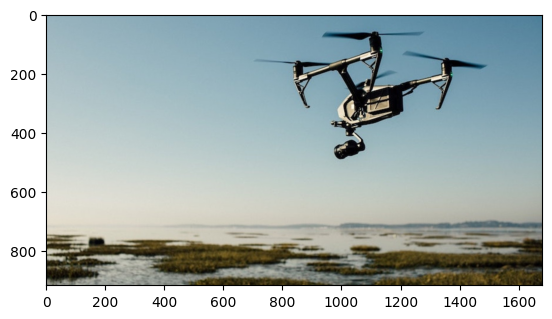


 prediction - drone 



In [138]:
classes = ['drone', 'notAdrone']


for pth in imgs:
  plt.imshow(Image.open(pth))
  plt.show()
  img = test_transform(Image.open(pth)).unsqueeze(0).to(device)
  output = model(img)
  _, predicted = torch.max(output.data, 1)
  print(f'\n prediction - {classes[predicted]} \n')